In [1]:
from pathlib import Path
import os
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from gym_recording_modified.playback import get_recordings
from utils.data_extractors import *
from utils.visualizations import *
import seaborn as sns
from scipy.stats import sem
from scipy.signal import convolve2d

In [115]:
root = Path('results_new_sweep')
filters = {
    'buffer_size' : [10000],
    'env': ['envs:random_maze-v0', 'CartPole-v1']}

cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, num_episodes = extract_num_episodes(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs)

976it [00:12, 75.96it/s]


KeyboardInterrupt: 

In [80]:
df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df = pd.concat([df1, df2], axis=1)
df.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Num Episodes']
df = df.drop(['Seed'],axis=1)
df['Algorithm'] = df['Model'] + ', ' + df['L'] 
df = df.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df = df.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df = df.replace('FFN, 10', 'DQN')
df = df.replace('FFN, 1', 'DQN')

df = df.replace('RNN, 1', 'DRQN, 1')
df = df.replace('RNN, 2', 'DRQN, 2')
df = df.replace('RNN, 4', 'DRQN, 4')
df = df.replace('RNN, 8', 'DRQN, 8')


In [81]:
df_mean = df.groupby(columns).mean().reset_index() # dataframe with mean over seeds for each parameter/alg/env configuration

# Total Number of episodes completed for all hyperparameters

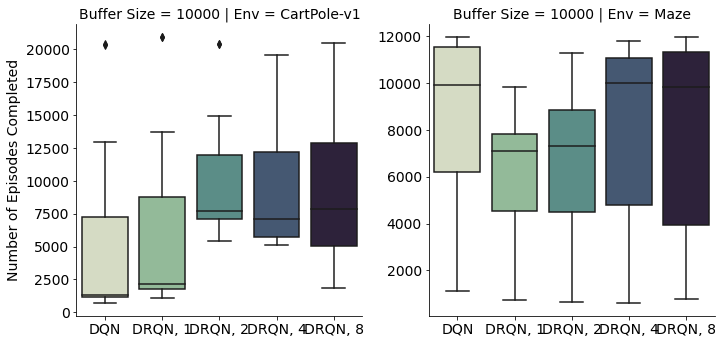

In [113]:
# Box plots of average number of episodes completed for all algorithms
g = sns.catplot(x='Algorithm', y='Num Episodes', row='Buffer Size', col='Env', data=df_mean, kind='box', sharey=False, palette= sns.cubehelix_palette(5, start=.5, rot=-.75).as_hex())
g.set_axis_labels("", "Number of Episodes Completed")
plt.savefig('figures/sensitivity.pdf', bbox_inches='tight')

In [83]:
def n_best_params(df, env, alg, n, columns, metric, maximize=True):
    '''
    returns the n best hyperparameter of alg on env accroding to metric column in df
    if maximize = True then higher numbers are better
    '''
    df_env_alg = df.loc[(df['Env'] == env) & (df['Algorithm'] ==alg)] # filtered by env and alg
    if maximize:
        df_env_alg = df_env_alg.nlargest(n, metric)
    else:
        df_env_alg = df_env_alg.nsmallest(n, metric)

    df_env_alg = df_env_alg.set_index(columns)
    inds = df_env_alg.index.tolist()

    return inds

In [84]:
def get_best_data(df, df_mean, columns, metric):
    '''
    Filters a dataframe to only include data from the best hyperparameters, as determined by df_mean
    '''
    inds = []
    for env in df['Env'].unique():
        for alg in df['Algorithm'].unique():
            if env == 'CartPole-v1': # fewer episodes completed is better for cartpole
                maximize = False
            else:
                maximize = True

            inds += n_best_params(df_mean, env, alg, 1, columns, metric, maximize=maximize)
    
    df_ = df.set_index(columns)
    df_ = df_.loc[inds]
    return df_.reset_index(), inds

## Total Number of episodes completed for best hyperparameters

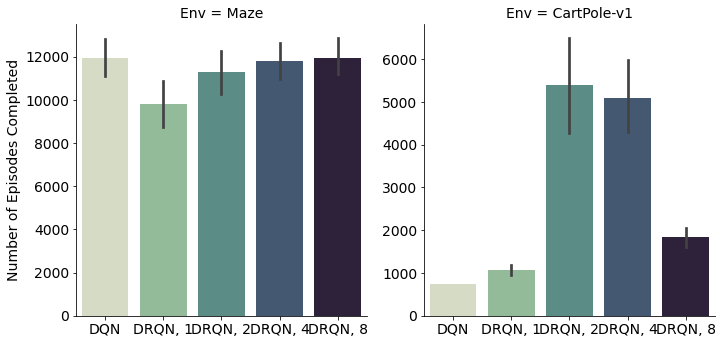

In [85]:
df_best, best_inds = get_best_data(df, df_mean, columns, 'Num Episodes')
g = sns.catplot(x='Algorithm', y='Num Episodes', col='Env', data=df_best, kind='bar', ci=68, sharey=False, palette= sns.cubehelix_palette(5, start=.5, rot=-.75))
g.set_axis_labels("", "Number of Episodes Completed")
plt.savefig('figures/total_episodes_best_params.pdf', bbox_inches='tight')

In [86]:
best_inds

[('DQN', 'Maze', '1', '10', '5e-05', '10000'),
 ('DRQN, 1', 'Maze', '1', '1', '0.0005', '10000'),
 ('DRQN, 2', 'Maze', '1', '100', '0.0005', '10000'),
 ('DRQN, 4', 'Maze', '1', '100', '5e-05', '10000'),
 ('DRQN, 8', 'Maze', '1', '1', '5e-05', '10000'),
 ('DQN', 'CartPole-v1', '1', '100', '0.0005', '10000'),
 ('DRQN, 1', 'CartPole-v1', '10', '100', '0.005', '10000'),
 ('DRQN, 2', 'CartPole-v1', '10', '1000', '0.005', '10000'),
 ('DRQN, 4', 'CartPole-v1', '1', '100', '5e-05', '10000'),
 ('DRQN, 8', 'CartPole-v1', '10', '1000', '0.005', '10000')]

## average episode length for best hyperparameters last 50 episodes

In [109]:
root = Path('results_best')
filters = None

cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, episode_len = extract_episode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs, last_n=30)

avg = np.zeros(episode_len.shape[0])
for i in range(episode_len.shape[0]):
    avg[i] = np.mean(episode_len[i])

df1 = pd.DataFrame(params)
df2 = pd.DataFrame(avg)
df_last = pd.concat([df1, df2], axis=1)
df_last.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Average Episode Length']
df_last = df_last.drop(['Seed'],axis=1)
df_last['Algorithm'] = df_last['Model'] + ', ' + df_last['L'] 
df_last = df_last.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df_last = df_last.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df_last = df_last.replace('FFN, 10', 'DQN')
df_last = df_last.replace('FFN, 1', 'DQN')

df_last = df_last.replace('RNN, 1', 'DRQN, 1')
df_last = df_last.replace('RNN, 2', 'DRQN, 2')
df_last = df_last.replace('RNN, 4', 'DRQN, 4')
df_last = df_last.replace('RNN, 8', 'DRQN, 8')


1000it [00:06, 159.07it/s]


In [104]:
root = Path('results_best')
filters = None

cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, num_episodes = extract_num_episodes(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs)


df1 = pd.DataFrame(params)
df2 = pd.DataFrame(num_episodes)
df_best = pd.concat([df1, df2], axis=1)
df_best.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Num Episodes']
df_best = df_best.drop(['Seed'],axis=1)
df_best['Algorithm'] = df_best['Model'] + ', ' + df_best['L'] 
df_best = df_best.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df_best = df_best.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df_best = df_best.replace('FFN, 10', 'DQN')
df_best = df_best.replace('FFN, 1', 'DQN')

df_best = df_best.replace('RNN, 1', 'DRQN, 1')
df_best = df_best.replace('RNN, 2', 'DRQN, 2')
df_best = df_best.replace('RNN, 4', 'DRQN, 4')
df_best = df_best.replace('RNN, 8', 'DRQN, 8')

1000it [00:00, 1861.78it/s]


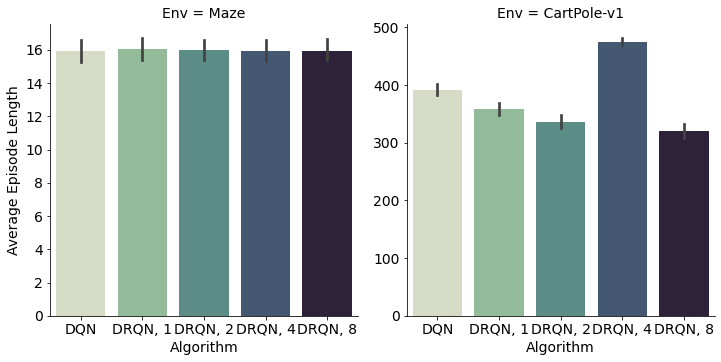

In [110]:

g = sns.catplot(x='Algorithm', y='Average Episode Length', col='Env', data=df_last, kind='bar', ci=68,  sharey=False, palette= sns.cubehelix_palette(5, start=.5, rot=-.75))
plt.savefig('figures/last_50_length_best_params.pdf', bbox_inches='tight')

In [111]:
df_temp = pd.concat([df_last.set_index(columns), df_best.set_index(columns)], axis=1)
df_temp = df_temp.reset_index()
df_temp = df_temp.drop(['Learning Freq.', 'Target Update Freq.',  'Step Size', 'Buffer Size'], axis=1)
df_temp = df_temp.melt(id_vars=['Algorithm', 'Env'], var_name = 'source', value_name='val')

[749.82, 777.95, 1237.67, 2010.4, 1298.53]
[391.37899999999996, 358.36566666666675, 336.55666666666673, 475.33, 321.1236666666666]
[13632.85, 13587.53, 13622.65, 13601.43, 13640.24]
[15.934666666666669, 16.01833333333333, 15.981999999999998, 15.951666666666659, 15.94466666666667]


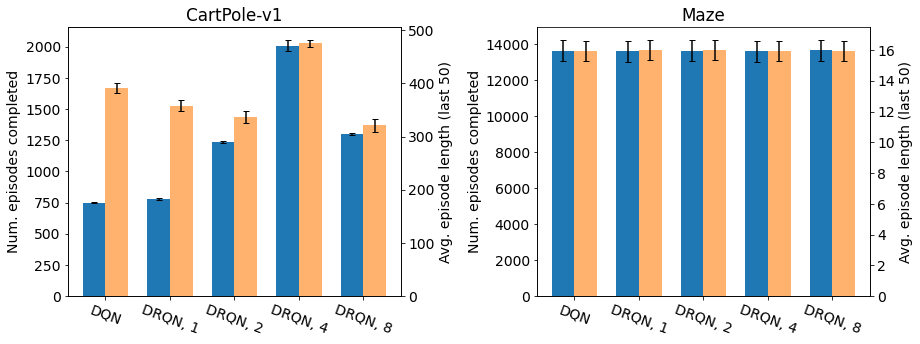

In [119]:
# double bar plot

font = {'size'   : 14}

matplotlib.rc('font', **font)
env_ind = 1

data = df_temp.values


algs =  np.unique(data[:, 0])
envs = np.unique(data[:, 1])

num_subplots = envs.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(13,5))


x = np.arange(len(algs))  # the label locations
width = 0.35  # the width of the bars

ax_idx = 0

colours = sns.cubehelix_palette(len(algs), start=.5, rot=-.75).as_hex()


for env in envs:
    ax = axs[ax_idx]
    data_num_episodes_to_plot = []
    data_ep_len_to_plot = []
    num_episodes_err = []
    ep_len_err = []
    scale = 1


    for alg in algs:
        data_num_episodes = data[np.where((data[:, 2] == 'Num Episodes') & (data[:, 1] ==env) & (data[:, 0] == alg))]
        data_ep_len = data[np.where((data[:, 2] == 'Average Episode Length') & (data[:, 1] ==env) & (data[:, 0] == alg))]       

        data_num_episodes_to_plot.append(np.mean(data_num_episodes[:, 3]))
        data_ep_len_to_plot.append(np.mean(data_ep_len[:, 3]* scale ))
        num_episodes_err.append(sem(data_num_episodes[:, 3]))
        ep_len_err.append(sem(data_ep_len[:, 3]))

    rects1 = ax.bar(x - width/2, data_num_episodes_to_plot, width, label='Num Episodes', color='tab:blue' )
    ax.errorbar(x - width/2, data_num_episodes_to_plot, yerr=num_episodes_err, ecolor='black', capsize=3, ls='none' )

    ax.set_ylabel('Num. episodes completed')
    ax.set_title(env)
    ax.set_xticks(x)
    ax.set_xticklabels(algs, rotation=340)
    ax2 = ax.twinx()
    ax2.set_ylabel('Avg. episode length (last 50)')

    rects2 = ax2.bar(x + width/2, data_ep_len_to_plot, width, label='Last 30 Episode Avg. Episode Length', color='tab:orange', alpha = 0.6)
    ax2.errorbar(x + width/2, data_ep_len_to_plot, yerr=ep_len_err, ecolor='black', capsize=3, ls='none' )
    ax_idx += 1

handles, labels = ax.get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center')
plt.xticks(rotation=290)
plt.gca().spines['top'].set_visible(False)
fig.tight_layout()
plt.savefig("figures/double_bar.pdf", bbox_inches='tight')

In [2]:
# learning curves
root = Path('results_best')
filters = None
cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, data = extract_episode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs)


1000it [00:05, 171.25it/s]


In [5]:
len(data[0])

11263

In [ ]:

completed = np.zeros(200000)
completed[np.cumsum(data[0]]] = 1




In [124]:
algs =  np.unique(params[:, 0])
envs = np.unique(params[:, 1])


for env in envs:
   
    for alg in algs:

        inds = np.where((params[:, 1]==env) & (params[:, 0]==alg))

        data_ = data[inds]
        params_ = data[inds]

        


    
    

